#### Visualising deals dataset to identify potential errors in the critical deal attribute.  
The 'Deal source' attrib tells us if it is a first time deal with a new customer or the repeated one. In addition for the first deal 'Deal source' shows which lead source the 1st deal is attributed to (possible options are 'Inbound', 'Outbound', 'Other', 'Offline Partner/Agent', 'Field/Offline event')     

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

%matplotlib inline

In [2]:
file2read = '/Users/andrew/Documents/2023 JUPYTER Notebook/swag42 notebooks/\
data/hubspot-crm-exports-deals-all-pieplienes-export-v-20240114.csv'

df = pd.read_csv(file2read) #, index_col = 'Record ID')

In [45]:
#df.info()

____Pre-processing____

In [12]:
#column names for dot addresing
df.columns = df.columns.str.replace(' ', '_')

In [5]:
#convert dates column into date types
df[['Create_Date', 'Close_Date']] = df[['Create_Date', 'Close_Date']]\
    .apply(pd.to_datetime)

In [46]:
#check nulls
df.isnull().sum()

Record_ID                       0
Deal_Name                       0
Deal_Stage                      0
Close_Date                      0
Deal_owner                      5
Associated_Company              0
int_Related_company_HC          3
Pipeline                        0
Amount_in_company_currency      0
Create_Date                     0
Deal_source                     0
Associated_Contact              2
Associated_Company_IDs          0
Associated_Contact_IDs          2
Split_Associated_Contact_IDs    2
Split_Associated_Company_IDs    0
Ass_Company_ID_1st              0
dtype: int64

In [7]:
#split ID's stirngs into lists with dtype = string
df['Split_Associated_Contact_IDs'] = df['Associated_Contact_IDs'].str.split(";")

df['Split_Associated_Company_IDs'] = df['Associated_Company_IDs'].str.split(";")

In [30]:
#check where a deal is associated with 1+ companies
#df[ df.Split_Associated_Company_IDs.apply(lambda x: len(x)) > 1]

In [9]:
#for simple get the first company ID into the add column
df['Ass_Company_ID_1st'] = df.Split_Associated_Company_IDs.apply(lambda x: x[0])

In [10]:
df.columns

Index(['Record_ID', 'Deal_Name', 'Deal_Stage', 'Close_Date', 'Deal_owner',
       'Associated_Company', 'int_Related_company_HC', 'Pipeline',
       'Amount_in_company_currency', 'Create_Date', 'Deal_source',
       'Associated_Contact', 'Associated_Company_IDs',
       'Associated_Contact_IDs', 'Split_Associated_Contact_IDs',
       'Split_Associated_Company_IDs', 'Ass_Company_ID_1st'],
      dtype='object')

___Drop the unnecessary columns___

In [31]:
col2drop= [ #'Record_ID', 
       'Deal_Name', 
        #'Deal_Stage', 'Close_Date', 'Deal_owner',
        #'Associated_Company', 'int_Related_company_HC', 'Pipeline',
        #'Amount_in_company_currency', 'Create_Date', 'Deal_source',
       'Associated_Contact', 
        #'Associated_Company_IDs',
       'Associated_Contact_IDs', 'Split_Associated_Contact_IDs',
       'Split_Associated_Company_IDs', 
        #'Ass_Company_ID_1st'
]
    
deals = df\
        .drop(col2drop, axis = 1)\
        .copy()

In [44]:
deals.Deal_source.unique()

array(['Existing customer', 'Inbound', 'Outbound', 'Other',
       'Offline Partner/Agent', 'Field/Offline event'], dtype=object)

In [47]:
#restore teh Del owner for 3 no owner deals
deals.Deal_owner = deals.Deal_owner.fillna('Redacted')

In [48]:
#drop n/a row in int_Related_company_HC column to keep it simple
deals = deals.dropna(axis = 0, how = 'any', subset = ['int_Related_company_HC'])

In [52]:
#add column with company counts to sort for some Customer Success stats => that comes later
deals['Deals_per_co'] = deals.groupby(by = 'Ass_Company_ID_1st')\
                                    ['Record_ID']\
                                    .transform('count')

In [53]:
#sort deals by N deals per Co, then by Co id, then by Deal create date
deals = deals.sort_values(['Deals_per_co', 'Create_Date'], 
                                                 ascending = [False, True])\
                                                        .reset_index(drop = True)

In [38]:
deals_gr_byCo = deals.groupby(by= 'Ass_Company_ID_1st', sort = False)

#get 1st row deal for each company
company_deals_1d = deals_gr_byCo.head(1)

#get 2nd rows deal for each company (deals have been sorted)
company_deals_2d = deals_gr_byCo.head(2)[ ~deals_gr_byCo.head(2).index.isin( company_deals_1d.index) ]

In [40]:
#deals_gr_byCo.ngroups
company_deals_1d.query('Deal_source != "Existing customer" and Deal_Stage == "Closed won"').shape

(105, 13)

__Visualising deal sources per customer account (company)__ 

In [41]:
import matplotlib.dates as mdates

In [42]:
color_map = {
              'Existing customer':'green', 
              'Inbound':'red', 
              'Outbound':'blue', 
              'Field/Offline event':'cyan',
              'Other':'grey', 
              'Offline Partner/Agent':'magenta'
             }

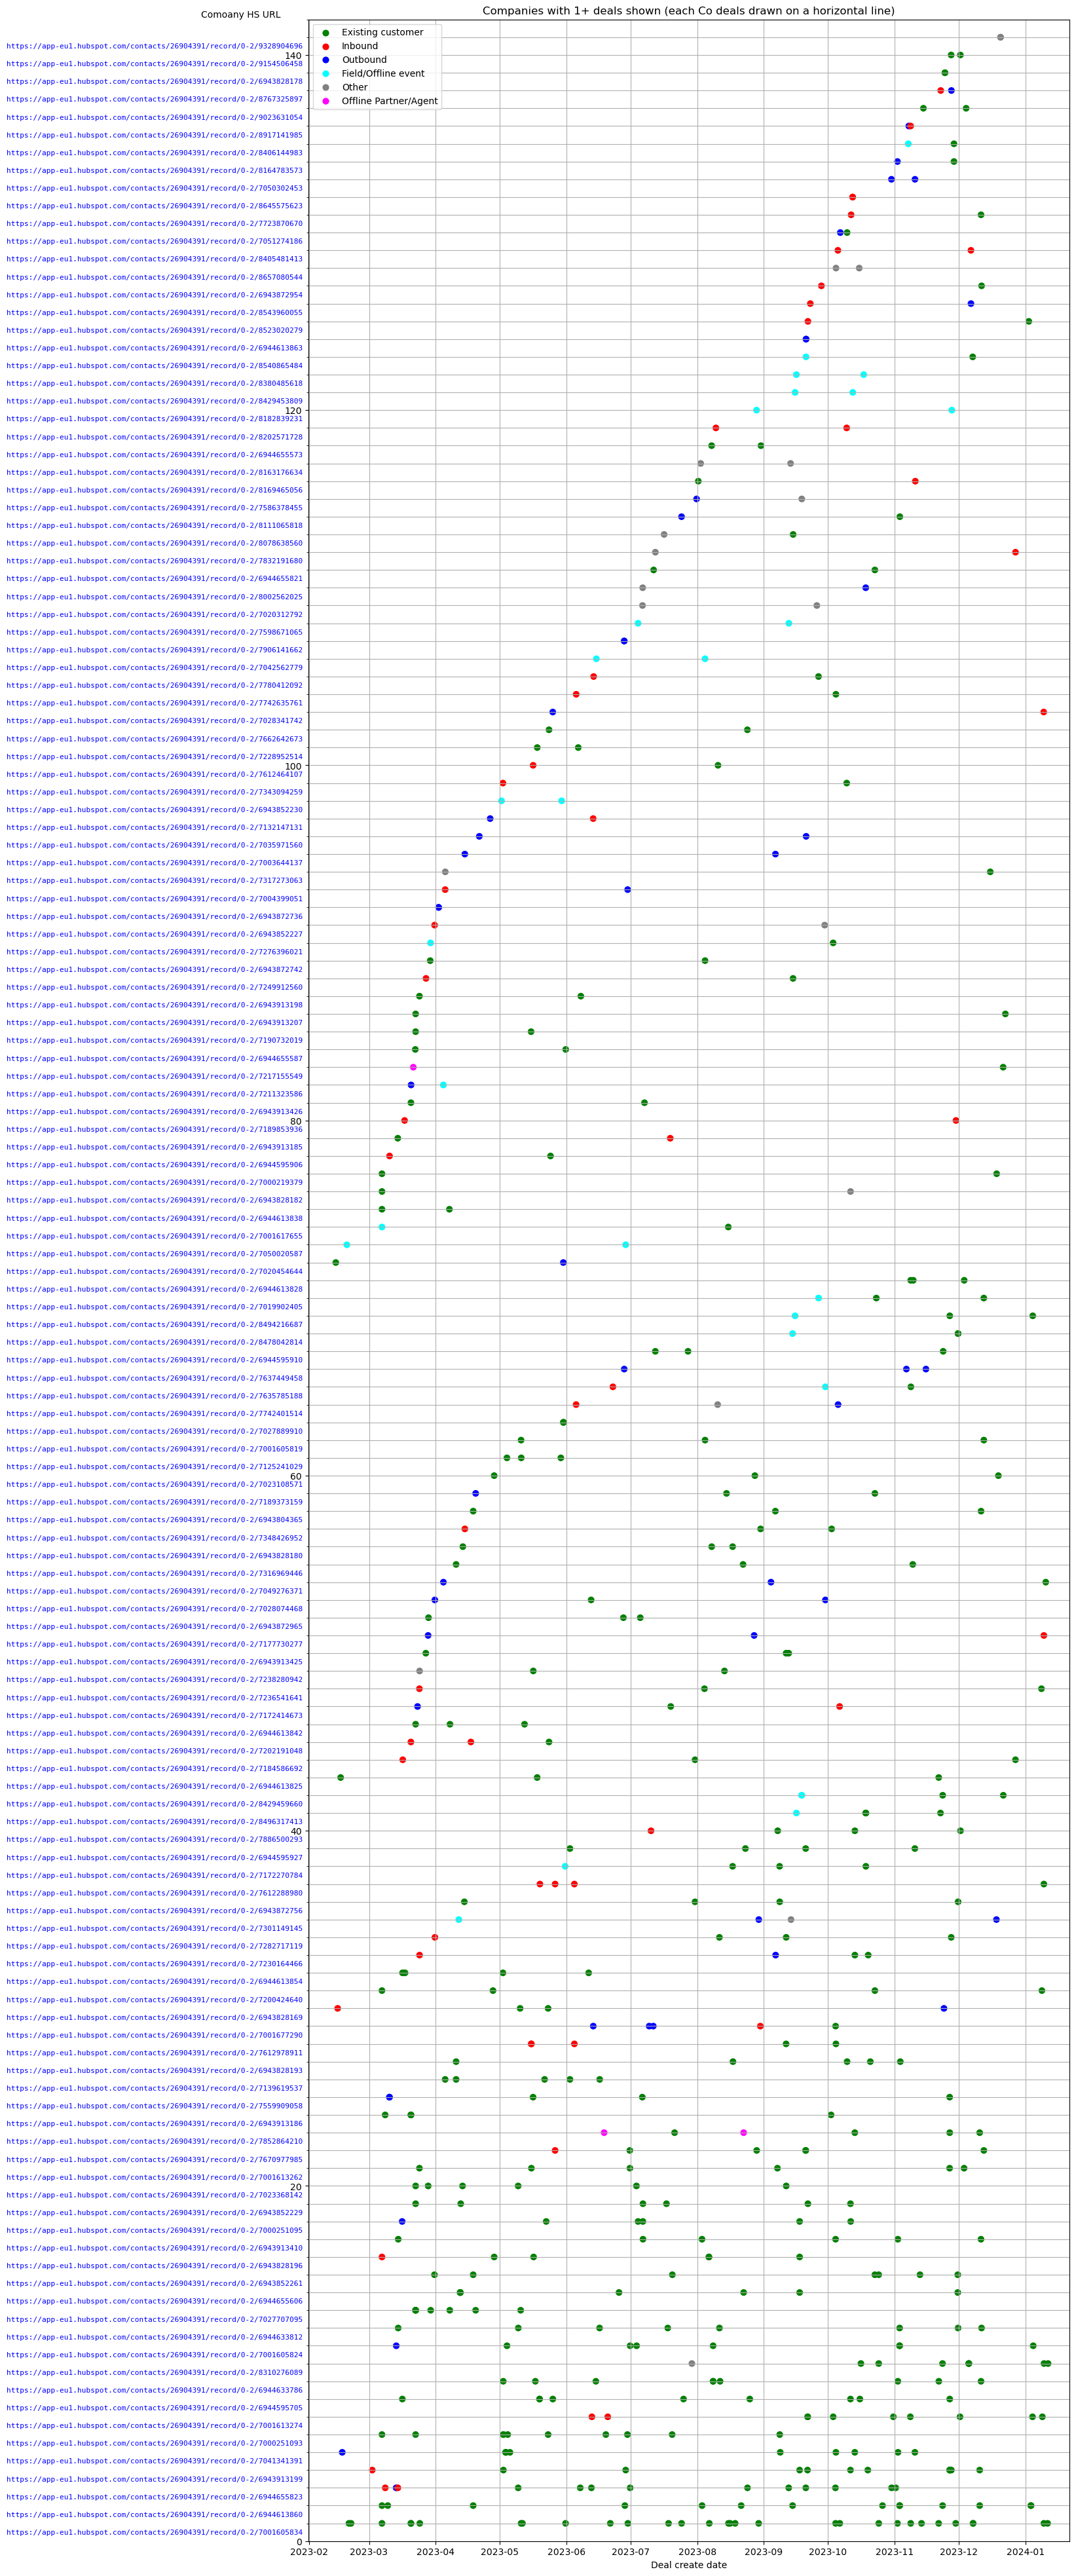

In [26]:
HS_Co_URL_prefix = 'https://app-eu1.hubspot.com/contacts/26904391/record/0-2/'

fig, ax = plt.subplots(figsize=(15, 50))

ax.set_yticks(np.arange(deals_gr_byCo.ngroups),  minor= True)


N_deals_drawn = 0
for i, (name, group) in enumerate(deals_gr_byCo):
    if len(group.index) > 1:
        X, Y = group.Create_Date, np.zeros(group.Create_Date.size) +1
        ax.scatter(X, Y+i, marker='o', s= 40, c = group.Deal_source.map(color_map))
        N_deals_drawn += 1

        ax.annotate(HS_Co_URL_prefix + name,
                    xy=(0.0, i+1), xycoords=ax.get_yaxis_transform(),
                    xytext=(-6, -12), textcoords='offset points',
                    color="blue", fontsize=8, ha="right", family="monospace")

ax.set_xlim(deals.Create_Date.min() - np.timedelta64(10,'D'),\
            deals.Create_Date.max() + np.timedelta64(10,'D'))

ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_locator(mdates.WeekdayLocator())    
ax.set_ylabel('Comoany HS URL', loc = 'top', rotation=0)

#ax.set_ylim(deals_gr_byCo.ngroups )
ax.set_ylim([0, N_deals_drawn + 1])
ax.set_xlabel('Deal create date')
        
ax.grid(which='both', axis='both')

leg = ax.legend(color_map.keys(), loc = 'upper left')
for handle, color_value in zip(leg.legend_handles, color_map.values()):
    handle.set_color(color_value)

ax.set_title('Companies with 1+ deals shown (each Co deals drawn on a horizontal line)');

#save this image to pdf
#fig.savefig('/Users/andrew/Downloads/deal_source_plot_Create_date.pdf', bbox_inches='tight')